In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch

from sentence_transformers import InputExample, SentenceTransformer, losses
from sentence_transformers.datasets import NoDuplicatesDataLoader
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# доступность гпу
torch.cuda.is_available()

True

In [3]:
# Загружаем данные
df_train = pd.read_excel('./data/aug_train.xlsx')
df_test =  pd.read_excel('./data/test_data.xlsx')

In [4]:
df_train.head()

,ITEM_NAME_x,ITEM_NAME_y
0,2х40 рубеж бр 12 бокс резервного электропитания,бокс резервного электропитания бр12 автоматики...
1,плита гипсовая пазогребневая влагостойкая пуст...,гипсовая влагостойкая пустотелая пгп плита плг...
2,"трубы вгп оц. 20х2,8мм","сталь труба 20х2,8мм вгп оцинкованная гост 326..."
3,труба гост вгп 80х4 оцинк 3262,труба стальная оцинкованная водогазопроводная ...
4,радиатор prado c1a88ic 21x500x600,радиатор панельный pkadu classic 21х500х600


In [5]:
df_test.head()

,ITEM_NAME_x,ITEM_NAME_y
0,старатели private label шпатлёвка гипсовая фин...,шпатлевка финишная гипсовая private label стар...
1,бетонная смесь бст в25 п4 f200w8 — |,бетон в25 гравий с пмд п2-п4 f200 w8 гост 2519...
2,лист стальной с ромбическим и чечевичным рифле...,лист стальной с ромбическим и чечевичным рифле...
3,пазогребневая плита волма влагостойкая 667x500...,плита гипсовая влагостойкая пустотелая пгп 667...
4,плита паг 14,плита дорожная паг-14


In [6]:
print(f'Размер трейн выборки: {df_train.shape}\nРазмер тест выборки: {df_test.shape}')

Размер трейн выборки: (8082, 2)
Размер тест выборки: (666, 2)


In [7]:
# Функция для создания датасета
def get_dataset(df):
    examples = []
    for _, row in df.iterrows():
        examples.append(InputExample(texts=[row['ITEM_NAME_x'], row['ITEM_NAME_y']]))
    return examples

In [8]:
# Создаем даталоудер
train_examples = get_dataset(df_train)
train_dataloader = NoDuplicatesDataLoader(train_examples, batch_size=16)

In [13]:
def evaluator(df, model, top_k=[1, 3, 5]):
    # Энкодим вопросы и ответы
    vectors_x = model.encode(df['ITEM_NAME_x'].values, batch_size=32)
    vectors_y = model.encode(df['ITEM_NAME_y'].values, batch_size=32)

    # Вычисляем косинусное сходство между каждым вопросом и каждым ответом
    cosine_scores = cosine_similarity(vectors_x, vectors_y)

    correct_counts = dict.fromkeys(top_k, 0)
    
    model_answers = []

    for i in range(len(cosine_scores)):
        top_indices = cosine_scores[i].argsort()[-max(top_k):][::-1]
        top_answers = df.ITEM_NAME_y.iloc[top_indices].values.tolist()
        model_answers.append(top_answers)
        for k in top_k:
            if i in top_indices[:k]:
                correct_counts[k] += 1
        
        evaluation_score = {f"Top-{k} Accuracy": count / len(cosine_scores) for k, count in correct_counts.items()}
        
    print(evaluation_score)
        
    df['model_answers'] = model_answers

    return df, evaluation_score

In [17]:
class MultipleNegativesRankingLossWithAvg(losses.MultipleNegativesRankingLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.total_loss = 0
        self.steps = 0

    def forward(self, sentence_features, labels):
        loss = super().forward(sentence_features, labels)
        self.total_loss += loss.item()
        self.steps += 1
        return loss

    def get_avg_loss(self):
        return self.total_loss / self.steps if self.steps > 0 else 0

In [14]:
# baseline
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2', device='cuda:2')
df_valid_processed, evaluation_score = evaluator(df_test, model)

{'Top-1 Accuracy': 0.3003003003003003, 'Top-3 Accuracy': 0.4894894894894895, 'Top-5 Accuracy': 0.5945945945945946}


In [11]:
df_valid_processed.sample(10)

,ITEM_NAME_x,ITEM_NAME_y,model_answers
318,арматура alll a500c 16x11700 гост 340282016,арматура а500с д 16 гост 34028-2016,"[арматура а500с д 16 гост 34028-2016, арматура..."
580,состав клеевой на минеральной основе capatect ...,клей для утеплителя capatect daemmkleber 185 w...,[смесь клеевая для минераловатных плит thermom...
14,вентиляционный блок бв 32.5.92 вб_тип_2.1 930х500,блок вентиляционный бв 32.5.9-2 930х500х3200мм,"[блок вентиляционный бв 30.93-1-нв, блок венти..."
201,накладка под фиксатор фнф цвет хром |,накладка под фиксатор фнф хром,"[накладка под фиксатор фнф хром, стакан монтаж..."
361,бетон m350 b25 гравий f200w8i14 дата отгрузки ...,бетон в25 гравий с пмд п2-п4 f200 w8 гост 2519...,[бетон в25 гравий с пмд п2-п4 f200 w8 гост 251...
312,плиты минераловатные техновент стандарт 1200x6...,плита минераловатная теплоизоляционная технони...,[плита минераловатная теплоизоляционная технон...
485,"провод пув 1х2,5 желтозеленый .","провод силовой пв-1 1х2,5 желто-зеленый гост 6...","[кабель ввг 3х2,5мм2, труба электросварная пря..."
231,радиатор prado classic 20x500x800,радиатор панельный prado classic 20х500х800,"[радиатор панельный prado classic 20х300х500, ..."
126,"труба вгп 32х3,2 гост 3262","труба вгп стальная 32х3,5 гост 3262-75","[труба вгп стальная 32х3,5 гост 3262-75, отвод..."
325,основит техно рс21/1 м штукатурка цементнопесч...,штукатурка цементно-песчаная техно pc21/1 m ос...,[штукатурка цементно-песчаная техно pc21/1 m о...


In [15]:
# Тюним модель
scores = []
loss_values = []

def train(
    train_dataloader,
    df_valid,
    num_iter,
    best_score=0.31,
    load_path='paraphrase-multilingual-mpnet-base-v2'
):
    warmup_steps = int(0.1 * len(train_dataloader))
    
    for _ in range(num_iter):
        model = SentenceTransformer(load_path, device='cuda:2')
        
        train_loss = MultipleNegativesRankingLossWithAvg(model=model)
        
        model.fit(train_objectives=[(train_dataloader, train_loss)],
                  epochs=2,
                  warmup_steps=warmup_steps,
                  show_progress_bar=True,
                  output_path='./models/base_model',
                 )
        
        loss_values.append(train_loss.get_avg_loss())
        
        df_valid, evaluation_score = evaluator(df_valid, model)
        scores.append(evaluation_score)
        
        with open('./evaluation_score.pickle', 'wb') as f:
            pickle.dump(scores, f)
        
        if evaluation_score['Top-1 Accuracy'] > best_score:
            load_path = './models/best_model'
            best_score = evaluation_score['Top-1 Accuracy']
            model.save(load_path)
            print('save!')
        else:
            load_path = './models/base_model'
            
    return  df_valid

In [18]:
%%time
df_valid = train(
    train_dataloader,
    df_test,
    num_iter=5,
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

{'Top-1 Accuracy': 0.5585585585585585, 'Top-3 Accuracy': 0.8243243243243243, 'Top-5 Accuracy': 0.9069069069069069}
save!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

{'Top-1 Accuracy': 0.6051051051051051, 'Top-3 Accuracy': 0.8378378378378378, 'Top-5 Accuracy': 0.9294294294294294}
save!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

{'Top-1 Accuracy': 0.5885885885885885, 'Top-3 Accuracy': 0.8228228228228228, 'Top-5 Accuracy': 0.9114114114114115}


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

{'Top-1 Accuracy': 0.6111111111111112, 'Top-3 Accuracy': 0.8318318318318318, 'Top-5 Accuracy': 0.9234234234234234}
save!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

Iteration:   0%|          | 0/505 [00:00<?, ?it/s]

{'Top-1 Accuracy': 0.6066066066066066, 'Top-3 Accuracy': 0.8483483483483484, 'Top-5 Accuracy': 0.9354354354354354}
CPU times: user 26min 12s, sys: 20min 23s, total: 46min 36s
Wall time: 39min 42s


In [23]:
def plot_metrics(loss_values, scores_train):
    plt.figure(figsize=(15, 15))

    # Подграфик для функции потерь
    plt.subplot(4, 1, 1)
    plt.plot(loss_values)
    plt.title('Loss values')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    # Подграфик для оценки обучения
    plt.subplot(4, 1, 2)
    train_scores_1 = [score['Top-1 Accuracy'] for score in scores_train]
    train_scores_2 = [score['Top-3 Accuracy'] for score in scores_train]
    train_scores_5 = [score['Top-5 Accuracy'] for score in scores_train]
    plt.plot(train_scores_1, label='Top-1')
    plt.plot(train_scores_2, label='Top-3')
    plt.plot(train_scores_5, label='Top-5')
    plt.title('Train accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

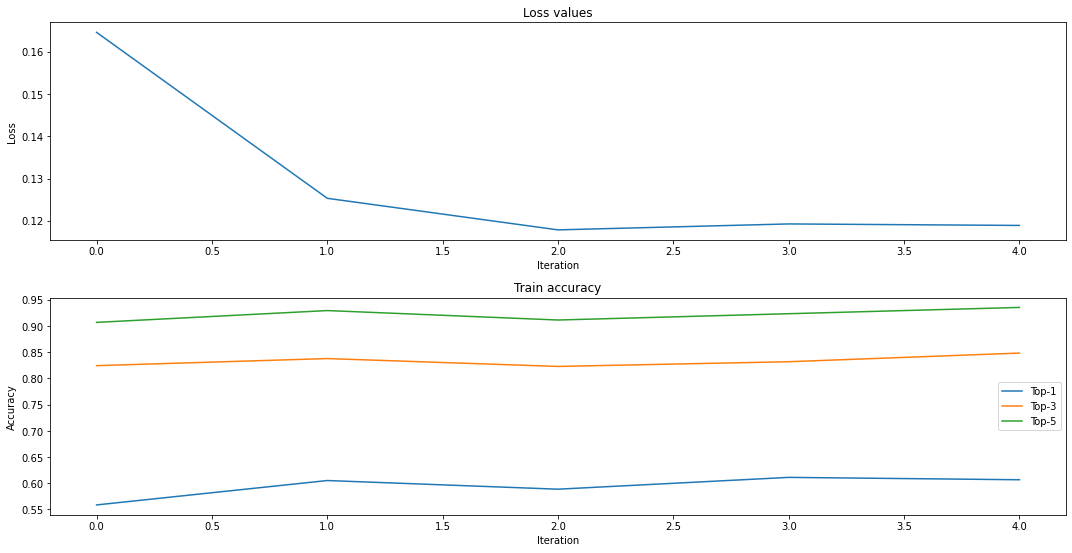

In [24]:
plot_metrics(loss_values, scores)